Laboratório de Redes de Computadores: Implementação e Análise do CRC

Aluno: João Vitor da Silva Souza - 122210993

Disciplina: Redes de Computadores

Objetivo: Estudo, implementação e análise do algoritmo Cyclic Redundancy Check (CRC) como técnica de verificação de integridade na camada de enlace.

In [2]:
!pip install crc

# Implementação Manual do Algoritmo CRC

### Funções auxiliares e implementação


In [3]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    r = len(gerador_bits) - 1

    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)
            janela_atual = "".join(mensagem_aumentada[inicio:fim])
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            for j in range(1, len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto

### Teste de Validação

In [4]:
dados_teste = "1101011111"
gerador_teste = "10011"

crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x):           {dados_teste}")
print(f"Gerador G(x):         {gerador_teste}")
print(f"CRC Calculado:        {crc_calculado}")

quadro_tx = dados_teste + crc_calculado
print(f"Quadro T(x) a enviar: {quadro_tx}")

Dados M(x):           1101011111
Gerador G(x):         10011
CRC Calculado:        0010
Quadro T(x) a enviar: 11010111110010


# Análise Comparativa de Desempenho

In [19]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16, Configuration

calculator_lib = Calculator(Crc16.MODBUS)

tamanhos_bytes = [1500, 3000 , 6000 , 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")

    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101")

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.2833321809998779, 'mem_pico_manual': 105.7587890625, 'tempo_lib': 0.08322385900009976, 'mem_pico_lib': 6.83984375}, {'tamanho': 3000, 'tempo_manual': 0.5667330660000971, 'mem_pico_manual': 211.2275390625, 'tempo_lib': 0.14675563900004818, 'mem_pico_lib': 51.4306640625}, {'tamanho': 6000, 'tempo_manual': 1.1358343309998418, 'mem_pico_manual': 422.1650390625, 'tempo_lib': 0.289386530999991, 'mem_pico_lib': 45.109375}, {'tamanho': 16000, 'tempo_manual': 3.0452041420001024, 'mem_pico_manual': 1125.2900390625, 'tempo_lib': 0.7627523190001284, 'mem_pico_lib': 44.1357421875}]


### Plotando os gráficos

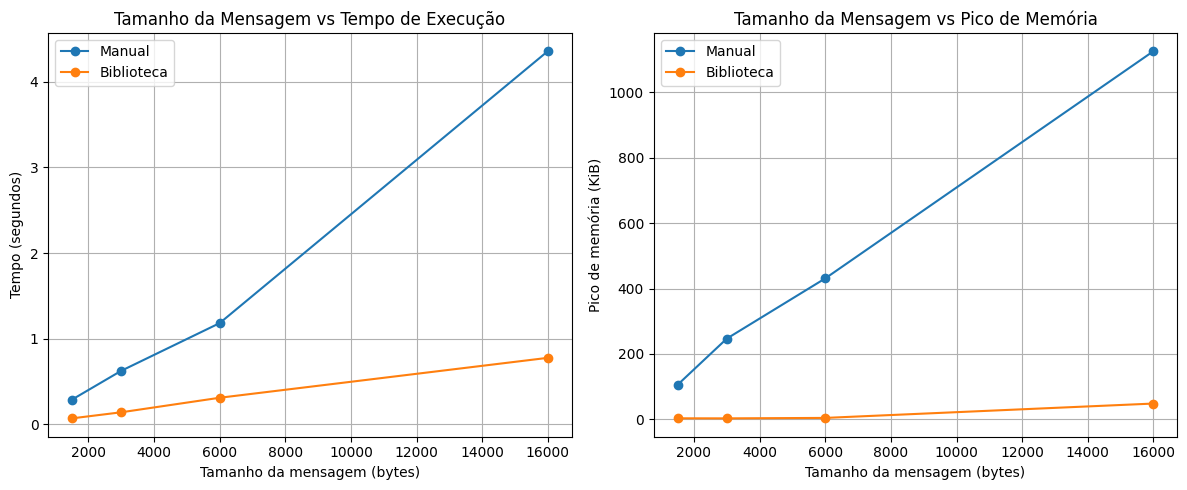

In [6]:
import matplotlib.pyplot as plt

tamanhos = [r["tamanho"] for r in resultados]

plt.figure(figsize=(12, 5))

# Gráfico 1 - Tempo de execução
plt.subplot(1, 2, 1)
plt.plot(tamanhos, [r["tempo_manual"] for r in resultados], marker='o', label="Manual")
plt.plot(tamanhos, [r["tempo_lib"] for r in resultados], marker='o', label="Biblioteca")
plt.title("Tamanho da Mensagem vs Tempo de Execução")
plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Tempo (segundos)")
plt.legend()
plt.grid(True)

# Gráfico 2 - Pico de memória
plt.subplot(1, 2, 2)
plt.plot(tamanhos, [r["mem_pico_manual"] for r in resultados], marker='o', label="Manual")
plt.plot(tamanhos, [r["mem_pico_lib"] for r in resultados], marker='o', label="Biblioteca")
plt.title("Tamanho da Mensagem vs Pico de Memória")
plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Pico de memória (KiB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Análise Investigativa da Detecção de Erros (Cenário Personalizado)

### Preparação do cenário

In [8]:
from crc import Calculator, Configuration

# Bits da string "Joao Vitor da Silva Souza" em ASCII
bits = "01001010011011110110000101101111001000000101011001101001011101000110111101110010001000000110010001100001001000000101001101101001011011000111011001100001001000000101001101101111011101010111101001100001"
polinomio_bin = "1100000100010001"

crc_manual = calcular_crc_manual(bits, polinomio_bin)
print("Mensagem: João Vitor da Silva Souza")
print(f"Mensagem Base: {bits}")
print(f"CRC: {crc_manual}")

Mensagem: João Vitor da Silva Souza
Mensagem Base: 01001010011011110110000101101111001000000101011001101001011101000110111101110010001000000110010001100001001000000101001101101001011011000111011001100001001000000101001101101111011101010111101001100001
CRC: 010111000010101


### Caça ao erros

In [34]:
import random
import pandas as pd

def inserir_erro_rajada(bits: str, n: int, pos: int) -> str:
    bits = list(bits)
    for i in range(n):
        if pos + i < len(bits):
            bits[pos + i] = '0' if bits[pos + i] == '1' else '1'
    return ''.join(bits)

relatorio = []

for i in range(10):
    crc = calcular_crc_manual(bits, polinomio_bin)
    quadro_tx = bits + crc

    if i == 6:
        n = 16
        pos = 10
    else:
        n = random.randint(1, 16)
        pos = random.randint(0, len(quadro_tx) - n)

    quadro_rx = inserir_erro_rajada(quadro_tx, n, pos)

    crc_manual_result = calcular_crc_manual(quadro_rx, polinomio_bin)
    quadro_bytes = bytes(int(quadro_rx[i:i+8], 2) for i in range(0, len(quadro_rx), 8))

    config = Configuration(width=16, polynomial=0x8005, init_value=0x0000, final_xor_value=0x0000,
                           reverse_input=False, reverse_output=False)
    calculator = Calculator(config)
    crc_lib_result = calculator.checksum(quadro_bytes)

    detectado_manual = crc_manual_result != '0' * (len(polinomio_bin) - 1)
    detectado_biblioteca = crc_lib_result != 0

    relatorio.append({
        "Teste": i+1,
        "Tamanho da Rajada": n,
        "Posição do Erro": pos,
        "Detectado Manual?": detectado_manual,
        "Detectado Biblioteca?": detectado_biblioteca,
        "Falhou Manual": not detectado_manual,
        "Falhou Biblioteca": not detectado_biblioteca
    })


df = pd.DataFrame(relatorio)
print(df.to_string(index=False))

 Teste  Tamanho da Rajada  Posição do Erro  Detectado Manual?  Detectado Biblioteca?  Falhou Manual  Falhou Biblioteca
     1                 11              112               True                   True          False              False
     2                 13              147               True                   True          False              False
     3                  6               79               True                   True          False              False
     4                 15               86               True                   True          False              False
     5                 14              172               True                   True          False              False
     6                 10              115               True                   True          False              False
     7                 16               10               True                   True          False              False
     8                  6              173      